<a id =t> </a> <br>
***

# <center> <span style="color:blue;background:yellow"> [WNS Analytics Wizard 2019](https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/) </span></center>

![](images/wns.png)
*** 

## Notebook Content
1. [Load Libraries](#0)
1. [Load Data](#1)
1. [Preprocessing](#a)
    1. [Process Logs and Items Data](#b)
    1. [Label Encoding](#2)
    1. [Date Columns Processing](#3)
1. [Feature Engineering](#4)
1. [LightGBM](#5)
    1. [Hyperparameters Optimization](#6)
    1. [Model Training and Prediction](#7)
    1. [Submission DataFrame](#8)

---

<a id=0> </a> <br>

## <span style="background:gray;color:red">1. </span><span style="background:yellow;color:blue">Load Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

/Users/0030/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


<a id=1> </a> <br>

## <span style="background:gray;color:red">2. </span><span style="background:yellow;color:blue">Load Data </span>

In [2]:
# Load Data
train = pd.read_csv('Data/train/train.csv')
test = pd.read_csv('Data/test.csv')

logs = pd.read_csv('Data/train/view_log.csv')  # Log details of user ids

items = pd.read_csv('Data/train/item_data.csv') # Item details


In [3]:
print('Shape of train Data :', train.shape, '\n Shape of test data :', test.shape)

Shape of train Data : (237609, 7) 
 Shape of test data : (90675, 6)


In [4]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [5]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


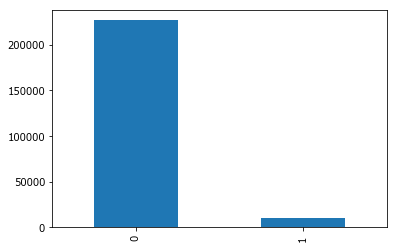

In [6]:
train['is_click'].value_counts().plot(kind='bar')

In [7]:
print('Click percentage :', train['is_click'].value_counts()[1]/train['is_click'].value_counts().sum()*100 , '%')

Click percentage : 4.571375663379754 %


In [8]:
logs.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [9]:
logs.shape

(3118622, 5)

In [10]:
items.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [11]:
items.shape

(132761, 6)

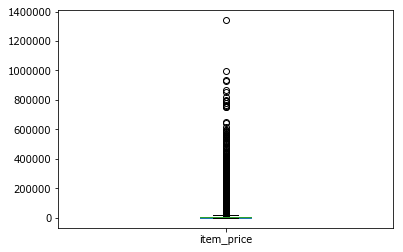

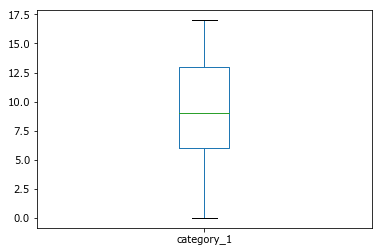

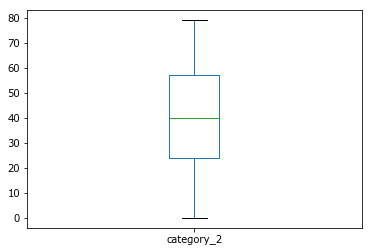

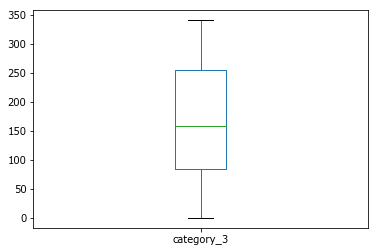

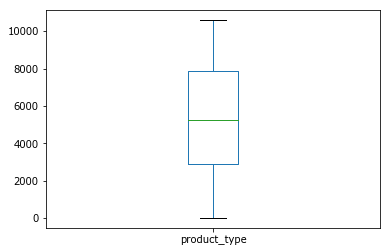

In [12]:
for col in items.columns[1:]:
    items[col].plot(kind='box')
    plt.show()

There are no outliers in items' variables but in product price.

<a id=a> </a> <br>

## <span style="background:gray;color:red">3. </span><span style="background:yellow;color:blue">Preprocessing </span>

In [13]:
target = train['is_click'] # Get labels 
train.drop('is_click', axis=1, inplace=True) # Remove labels

<a id=b> </a> <br>

### <span style="background:gray;color:red">3.1 </span><span style="background:yellow;color:blue">Process Logs and Items Data </span>
* Merge Logs and Items DataFrame on `item_id`
* Merge new train and test DataFrames with Logs and Items merge DataFrame on `user_id'
* Create a Pivot table---> Make  pivot table with  `impression_id` as index , choose columns and define opeartions on them.
* Reset index of Pivot Table
* Rename columns of Pivot Table
* Merge Train and Test DataFrame with Pivot Table on `impression_id` 

In [14]:
df1 = pd.merge(logs,items, on='item_id', how="left")

In [15]:
%%time
def process_log_item(df):
    df_new = pd.merge(df,df1, on ="user_id", how="left")
    
    df_new = pd.pivot_table(df_new, index ='impression_id', 
               values=['user_id','item_id', 'item_price','category_1','category_2','category_3', 'product_type'], 
              aggfunc={'user_id':len,'item_id': lambda x:len(set(x)),
                       'item_price':[np.median,np.sum],
                       'category_1':[np.min, np.mean, np.max],
                       'category_2':[np.min, np.mean, np.max],
                       'category_3':[np.min, np.mean, np.max],
                       'product_type':[np.min, np.max]
                      })
    df_new = df_new.reset_index()
    
    df_new.columns = ['impression_id','cat1_max', 'cat1_min', 'cat1_mean',
                    'cat2_max', 'cat2_min', 'cat2_mean',
                    'cat3_max', 'cat3_min', 'cat3_mean',
                     'item_count',
                    'price_median', 'price_sum',
                    'product_type_max', 'product_type_min',
                    'impression_count']
    df = pd.merge(df,df_new, on ="impression_id", how="left" )
    return df

train = process_log_item(train)
test = process_log_item(test)

CPU times: user 32.4 s, sys: 4.44 s, total: 36.8 s
Wall time: 38.8 s


In [16]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,...,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,11.0,11.0,11.000000,35.0,...,35.000000,20.0,20.0,20.000000,1,2350.0,2350.0,5622.0,5622.0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,13.0,4.0,7.333333,76.0,...,67.000000,295.0,67.0,257.500000,7,3421.0,53434.0,9337.0,577.0,12
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,13.0,8.0,10.500000,67.0,...,44.000000,170.0,139.0,154.500000,2,1598.5,3197.0,2874.0,2325.0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,17.0,0.0,9.277778,63.0,...,44.333333,313.0,20.0,159.444444,12,2307.0,179341.0,9959.0,1943.0,18
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,17.0,1.0,9.978261,76.0,...,32.652174,332.0,11.0,168.391304,34,3596.5,396471.0,10412.0,248.0,46


In [17]:
rm_col=['impression_id']

In [18]:
train1 = train.drop(rm_col, axis=1)

test1 = test.drop(rm_col, axis=1)

In [19]:
print('Shape of train Data :', train1.shape, '\n Shape of test data :', test1.shape)

Shape of train Data : (237609, 20) 
 Shape of test data : (90675, 20)


In [20]:
train1 = train1.fillna(0)
test1 = test1.fillna(0)

In [21]:
test1.head()

,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,2018-12-13 07:44:00,44754,127,latest,1,1.0,1.0,1.000000,42.0,42.0,42.000000,220.0,220.0,220.000000,1,23424.0,23424.0,1617.0,1617.0,1
1,2018-12-13 07:45:00,29656,44,latest,0,17.0,0.0,9.638889,78.0,3.0,38.430556,336.0,15.0,138.000000,46,3840.0,774171.0,10059.0,507.0,72
2,2018-12-13 07:46:00,25234,296,latest,1,17.0,7.0,12.555556,46.0,0.0,20.444444,328.0,4.0,201.222222,7,2116.0,44771.0,5552.0,60.0,9
3,2018-12-13 07:47:00,22988,207,latest,1,17.0,0.0,7.162162,76.0,0.0,33.108108,338.0,84.0,219.432432,17,5248.0,555344.0,9776.0,344.0,37
4,2018-12-13 07:48:00,35431,242,latest,1,17.0,0.0,8.178571,78.0,3.0,36.678571,308.0,18.0,143.285714,26,3105.0,245792.0,10412.0,1349.0,28


<a id=2> </a> <br>

### <span style="background:gray;color:red">3.2 </span><span style="background:yellow;color:blue">LabelEncoding </span>

* Do label encoding for `os_version` column

In [22]:
encode_cols = ['os_version'] #, 'device_type']
def labelencpode(df):
    enc = LabelEncoder()
    for col in encode_cols:
        enc.fit(df[col])
        df[col] = enc.transform(df[col])
    return df
train1 = labelencpode(train1)
test1 = labelencpode(test1)

In [23]:
train1.head()

,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,2018-11-15 00:00:00,87862,422,2,0,11.0,11.0,11.000000,35.0,35.0,35.000000,20.0,20.0,20.000000,1,2350.0,2350.0,5622.0,5622.0,1
1,2018-11-15 00:01:00,63410,467,1,1,13.0,4.0,7.333333,76.0,43.0,67.000000,295.0,67.0,257.500000,7,3421.0,53434.0,9337.0,577.0,12
2,2018-11-15 00:02:00,71748,259,0,1,13.0,8.0,10.500000,67.0,21.0,44.000000,170.0,139.0,154.500000,2,1598.5,3197.0,2874.0,2325.0,2
3,2018-11-15 00:02:00,69209,244,1,1,17.0,0.0,9.277778,63.0,21.0,44.333333,313.0,20.0,159.444444,12,2307.0,179341.0,9959.0,1943.0,18
4,2018-11-15 00:02:00,62873,473,1,0,17.0,1.0,9.978261,76.0,0.0,32.652174,332.0,11.0,168.391304,34,3596.5,396471.0,10412.0,248.0,46


<a id=3> </a> <br>

### <span style="background:gray;color:red">3.3 </span><span style="background:yellow;color:blue">Date Columns Processing </span>

* Convert `impression_time` column to datetime format
* Get month, day of week, day of month and hour 

In [24]:
def date_col(df):
  df['impression_time'] = pd.to_datetime(df['impression_time'])
  df['dow'] = df['impression_time'].apply(lambda x: x.weekday())
  df["day"]  = df['impression_time'].apply(lambda x: x.day)
  df['hour'] = df['impression_time'].apply(lambda x: x.hour)
  df.drop('impression_time', axis=1, inplace=True)
  return df

train1 = date_col(train1)
test1 = date_col(test1)

<a id=4> </a> <br>

## <span style="background:gray;color:red">4. </span><span style="background:yellow;color:blue">Feature Engineering </span>

#### `I found high correlation between categories, item count, product type, and item price. To reduce correlation among them, I took ratios. It did not reduce correlation between target and independent variables.`  

In [25]:
rm_cols = ['cat1_max', 'cat1_min', 'cat1_mean','cat2_max', 'cat2_min', 'cat2_mean',
                    'cat3_max', 'cat3_min', 'cat3_mean','price_median', 'price_sum',
                    'product_type_max', 'product_type_min', 'item_count', 'impression_count']
def feat_eng(df):
    df['cat1'] = df['cat1_max']/(df['cat1_min'] + 1)
    df['cat12'] = df['cat2_max']/(df['cat2_min'] + 1)
    df['cat3'] = df['cat3_max']/ (df['cat3_min'] + 1)
    df['product_type'] = df['product_type_max'] /(df['product_type_min'] + 1)
    df['price_ratio'] = df['price_sum'] / df['price_median']
    df['f1'] = (df['cat1_mean'] + df['cat2_mean'] + df['cat3_mean'])/(df['item_count'] + df['impression_count'] )
    df['f2'] = df['item_count']/df['impression_count']
    df.drop(rm_cols, axis=1, inplace=True)
    return df
train1 = feat_eng(train1)
test1 = feat_eng(test1)

In [26]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price_ratio,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


In [27]:
print('Shape of train Data :', train1.shape, '\n Shape of test data :', test1.shape)

Shape of train Data : (237609, 14) 
 Shape of test data : (90675, 14)


In [28]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price_ratio,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


In [29]:
train1['is_click'] = target

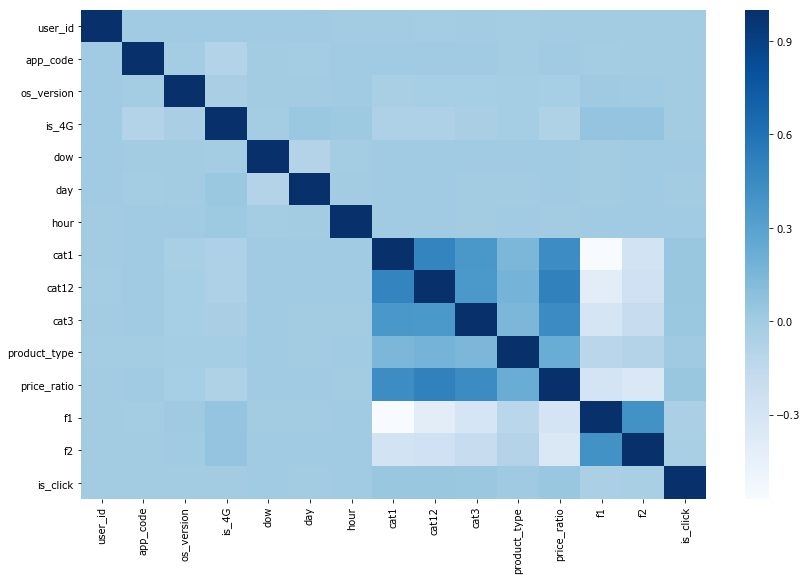

In [30]:
# Plot Correlation 
plt.subplots(figsize=(14,9))
data = train1.corr()
sns.heatmap(data, cmap ='Blues')

In [31]:
data

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price_ratio,f1,f2,is_click
user_id,1.000000,0.000247,0.000619,0.000256,0.000825,0.001182,-0.006041,-0.002955,-0.011365,-0.003811,-0.009125,-0.003513,-0.001710,-0.002427,-0.001035
app_code,0.000247,1.000000,-0.008514,-0.081480,-0.005307,-0.008427,0.005997,0.003847,0.008389,0.007791,-0.007528,0.011439,-0.009960,-0.005235,-0.005449
os_version,0.000619,-0.008514,1.000000,-0.042513,-0.005353,-0.000696,0.001977,-0.031589,-0.021853,-0.021585,-0.016613,-0.024344,0.013109,0.000392,-0.004383
is_4G,0.000256,-0.081480,-0.042513,1.000000,-0.008040,0.031951,0.021178,-0.058799,-0.067452,-0.041895,-0.012725,-0.068685,0.054971,0.059102,-0.003464
dow,0.000825,-0.005307,-0.005353,-0.008040,1.000000,-0.090244,-0.008548,0.005072,0.008550,0.004596,0.005961,0.007911,-0.002677,0.001740,0.005079
day,0.001182,-0.008427,-0.000696,0.031951,-0.090244,1.000000,-0.000754,0.004307,-0.000254,-0.005244,-0.004282,-0.000159,-0.003164,0.003610,-0.005490
hour,-0.006041,0.005997,0.001977,0.021178,-0.008548,-0.000754,1.000000,0.002051,0.004222,-0.003659,0.001984,-0.004091,0.000783,0.000943,0.004081
cat1,-0.002955,0.003847,-0.031589,-0.058799,0.005072,0.004307,0.002051,1.000000,0.494989,0.369171,0.151979,0.438605,-0.571177,-0.271754,0.041209
cat12,-0.011365,0.008389,-0.021853,-0.067452,0.008550,-0.000254,0.004222,0.494989,1.000000,0.365118,0.171969,0.511105,-0.401906,-0.247889,0.038332
cat3,-0.003811,0.007791,-0.021585,-0.041895,0.004596,-0.005244,-0.003659,0.369171,0.365118,1.000000,0.152939,0.446636,-0.304923,-0.196411,0.031438


<span style='color:blue;background:yellow;font-size:20px'> `High correlation between independent variables doesn't affect boosting aglorithms as they take one variable at a time for split.Therefore, it is upto you, if you drop highly correlated variable or not.`  </span>

In [32]:
train1.drop('is_click', axis=1, inplace=True)

In [33]:
cat_cols = ['user_id','app_code', 'os_version', 'is_4G', 'dow', 'hour', 'day'] 

In [34]:
cat_feat =cat_cols

<a id=5> </a> <br>

## <span style="background:gray;color:red">5. </span><span style="background:yellow;color:blue">LightGBM </span>

<a id=6> </a> <br>

### <span style="background:gray;color:red">5.1 </span><span style="background:yellow;color:blue">Hyperparameters Optimization</span>

#### [Hyperparameters Optimization Tutorial](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9) 


In [35]:
# Objective Function
train_data = lgb.Dataset(data=train1, label=target, free_raw_data=False)
evals_result = {}
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': 1500,
                  'learning_rate':0.05, 'early_stopping_round':150,
                  'metric':'auc'} # ,'boost_from_average':False}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=5, seed=11,
                           stratified=True,categorical_feature=cat_feat,
                            verbose_eval =None)
        return max(cv_result['auc-mean'])

In [36]:
pbs = {'num_leaves': (200, 300),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (11, 29),
        'lambda_l1': (0, 2),
        'lambda_l2': (0, 3),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (1, 10)
      }

In [37]:
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=109)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7374   |  0.9223   |  0.4931   |  1.399    |  0.5837   |  24.95    |  7.371    |  0.03714  |  297.2    |
|  2        |  0.7374   |  0.8186   |  0.431    |  0.1221   |  0.8978   |  28.93    |  9.292    |  0.0458   |  291.9    |
|  3        |  0.7373   |  0.8583   |  0.5483   |  0.9183   |  0.05462  |  28.08    |  3.797    |  0.08432  |  202.2    |
|  4        |  0.7356   |  0.9162   |  0.5833   |  1.696    |  0.9446   |  27.99    |  7.668    |  0.09032  |  286.7    |
|  5        |  0.7341   |  0.9802   |  0.6788   |  1.054    |  2.295    |  14.98    |  7.737    |  0.07712  |  237.9    |
|  6        |  0.7395   |  0.8414   |  0.4266   |  1.309    |  1.401    |  28.63    |  2.38     |  0.03153  |  200.1    |
|  7        |  0.7359   

In [38]:
optimizer.max

{'target': 0.7403495002610115,
 'params': {'bagging_fraction': 0.9307035525030026,
  'feature_fraction': 0.3809677711737022,
  'lambda_l1': 1.5178504819418857,
  'lambda_l2': 0.18953613571006867,
  'max_depth': 28.891357332845182,
  'min_child_weight': 1.0254070634916532,
  'min_split_gain': 0.013795321242820385,
  'num_leaves': 200.53307432227535}}

In [39]:
p =optimizer.max['params']

In [40]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learing_rate':0.01,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': {'auc'},
         'is_unbalance': True,}
         # 'boost_from_average': False}

In [41]:
param

{'num_leaves': 201,
 'feature_fraction': 0.3809677711737022,
 'bagging_fraction': 0.9307035525030026,
 'max_depth': 29,
 'lambda_l1': 1.5178504819418857,
 'lambda_l2': 0.18953613571006867,
 'min_split_gain': 0.013795321242820385,
 'min_child_weight': 1.0254070634916532,
 'learing_rate': 0.01,
 'objective': 'binary',
 'boosting_type': 'gbdt',
 'verbose': 1,
 'metric': {'auc'},
 'is_unbalance': True}

<a id=7> </a> <br>

### <span style="background:gray;color:red">5.2 </span><span style="background:yellow;color:blue">Model Training and Prediction</span>

In [42]:
%%time
nfold = 10

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=127)

oof = np.zeros(len(train1))
predictions = np.zeros(len(test1))

i = 1
for train_index, valid_index in skf.split(target, target.values):
    print("fold {}".format(i))
    xg_train = lgb.Dataset(train1.iloc[train_index],
                           label=target[train_index],
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train1.iloc[valid_index],
                           label=target[valid_index],
                           free_raw_data = False
                           )   
    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid],
                    categorical_feature=cat_feat,
                    verbose_eval=100, early_stopping_rounds = 50)
    
    oof[valid_index] = clf.predict(train1.iloc[valid_index], num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test1, num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.4f}".format(roc_auc_score(target, (oof))))

fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[44]	valid_0's auc: 0.729662
fold 2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.732083
Early stopping, best iteration is:
[74]	valid_0's auc: 0.734079
fold 3
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.725296
Early stopping, best iteration is:
[57]	valid_0's auc: 0.728672
fold 4
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.732982
Early stopping, best iteration is:
[70]	valid_0's auc: 0.734718
fold 5
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.73211
Early stopping, best iteration is:
[56]	valid_0's auc: 0.736954
fold 6
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.72719
Early stopping, best iteration is:
[74]	valid_0's auc: 0.728938
fold 7
Training until validation scores don't improve 

In [ ]:
predictions

<a id=8> </a> <br>

### <span style="background:gray;color:red">5.3</span><span style="background:yellow;color:blue">Submission DataFrame</span>

In [203]:
sub = pd.read_csv('Data/sample_submission.csv')

In [204]:
sub['is_click'] = predictions

In [205]:
sub.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.161062
1,caac14a5bf2ba283db7708bb34855760,0.104241
2,13f10ba306a19ce7bec2f3cae507b698,0.521529
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.230656
4,bf5a572cca75f5fc67f4b14e58b11d70,0.763745


In [206]:
sub.to_csv('sub_lgbm.csv', index =False)



## <center><span style="background:gray;color:red">End of the NoteBook</span></center>
***

### <center><span style="background:yellow;color:blue">[GO TO TOP](#t)</span></center> 